# Assignment 1 Group B5

### Exploratory Question:
##### Is domestic unrest associated with distinct rheotoric patterns in UNGC speeches? Specifically, do countries experiencing high unrest employ different rhetorical patterns compared to stable countries, and how are these rhetorical differences related to levels of national happiness?

### Predictive Question:
#####  Can the features extracted from UNGA speeches, be used to forecast the likelihood of domestic unrest in the following year?

In [127]:
from pathlib import Path
import pandas as pd
from glob import glob
import os
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk import ngrams
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [128]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('words')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/swastik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/swastik/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/swastik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/swastik/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# a) Data Collection and Preparation

## Importing UNGC Speech Data
This code loops from the folders of TXT and takes every .txt file that does not start with ._ which contain the speeches per country per year. These are then added to a dataframe, storing the year, country code and the speech

In [129]:
path = Path("/home/swastik/Downloads/UNGDC_1946-2024(1)//TXT")

# path = Path.cwd() / "TXT"

name_text = []
for folder in path.iterdir():
    if folder.is_dir():
        files = [f for f in folder.glob("*.txt") if not f.name.startswith("._")]

        for file in files:
            name = file.name
            text = file.read_text(encoding="utf-8")
            
            name_text.append({
                        "country": name[:3],
                        "year": name[-8:-4],
                        "speech": text
                    })
    
df = pd.DataFrame(name_text)

df.head(5)


,country,year,speech
0,YEM,2013,"Allow \nme, at the outset to extend sincere my..."
1,NER,2013,It is a great \nhonour for me to take the floo...
2,SWZ,2013,It is a great pleasure for me to have \nthis o...
3,MNG,2013,Allow me to first congratulate \nMr. John Ashe...
4,SGP,2013,I warmly \ncongratulate Mr. John Ashe on his e...


In [130]:
df.tail(5)

,country,year,speech
3283,DEU,2019,"Here in New York over the past few days, we ha..."
3284,MKD,2019,My country has been a Member of the United Nat...
3285,LAO,2019,"At the outset, I would like to congratulate Pr..."
3286,GUY,2019,I bring to President Tijjani Muhammad-Bande fr...
3287,GRD,2019,I extend cordial greetings from the Government...


## Punctuation - Stopwords - Tokenizing
The following code removes all punctuation from the texts, it also tokenizes the string (returns a list of each word separately as a string) and removes stopwords from it and non alphabetical tokens

https://www.geeksforgeeks.org/nlp/removing-stop-words-nltk-python/ 

https://www.geeksforgeeks.org/python/python-remove-punctuation-from-string/

We also remove words that are related to countries as can be found in the CSV file

https://en.wikipedia.org/wiki/List_of_adjectival_and_demonymic_forms_for_countries_and_nations

In [131]:
countries_df = pd.read_csv("List_of_adjectival_and_demonymic_forms_for_countries_and_nations_1.csv")
countries_flat = countries_df.values.ravel().tolist()
countries = []

def split_small_capital(text):
    split = re.sub(r'([a-z])([A-Z])', r'\1 \2', text).split()
    countries.extend(split)

for country_adj in countries_flat: split_small_capital(country_adj)

countries = [country.lower()for country in countries]

In [132]:
stop_words = set(stopwords.words('english'))
english_vocab = set(words.words())

df_tokenize = df.copy()

def punc_stop_token_english(speech: str):
    # Remove punctuation
    speech_no_punctuation = re.sub(r'[^\w\s]', '', speech)
    
    # Tokenize and lowercase
    tokens = word_tokenize(speech_no_punctuation.lower())
    
    # POS tagging
    pos_tags = pos_tag(tokens)
    
    # Keep only words that:
    # - are alphabetic
    # - are not stopwords
    # - are not proper nouns (NNP, NNPS)
    # - are in English vocabulary
    new_speech = [
        word for word, tag in pos_tags
        if (word.isalpha()) 
        and (word not in stop_words)
        and (tag not in ['NNP', 'NNPS'])
        and (word in english_vocab)
    ]
    
    return new_speech

# Apply to our object dataframe
df_tokenize['speech_token'] = df_tokenize['speech'].apply(punc_stop_token_english)
df_tokenize.head(5)

,country,year,speech,speech_token
0,YEM,2013,"Allow \nme, at the outset to extend sincere my...","[allow, outset, extend, sincere, ambassador, p..."
1,NER,2013,It is a great \nhonour for me to take the floo...,"[great, take, floor, session, general, assembl..."
2,SWZ,2013,It is a great pleasure for me to have \nthis o...,"[great, pleasure, opportunity, join, fellow, s..."
3,MNG,2013,Allow me to first congratulate \nMr. John Ashe...,"[allow, first, congratulate, assuming, preside..."
4,SGP,2013,I warmly \ncongratulate Mr. John Ashe on his e...,"[warmly, congratulate, election, president, se..."


## Word Frequency
Unigrams (e.g., “peace”, “war”, “growth”) capture general rhetoric.
Bigrams (e.g., “human rights”, “climate change”, “economic development”) capture rhetorical style and key phrases.
Using both gives a richer feature space , creating more nuance when comparing countries with high vs. low polarisation

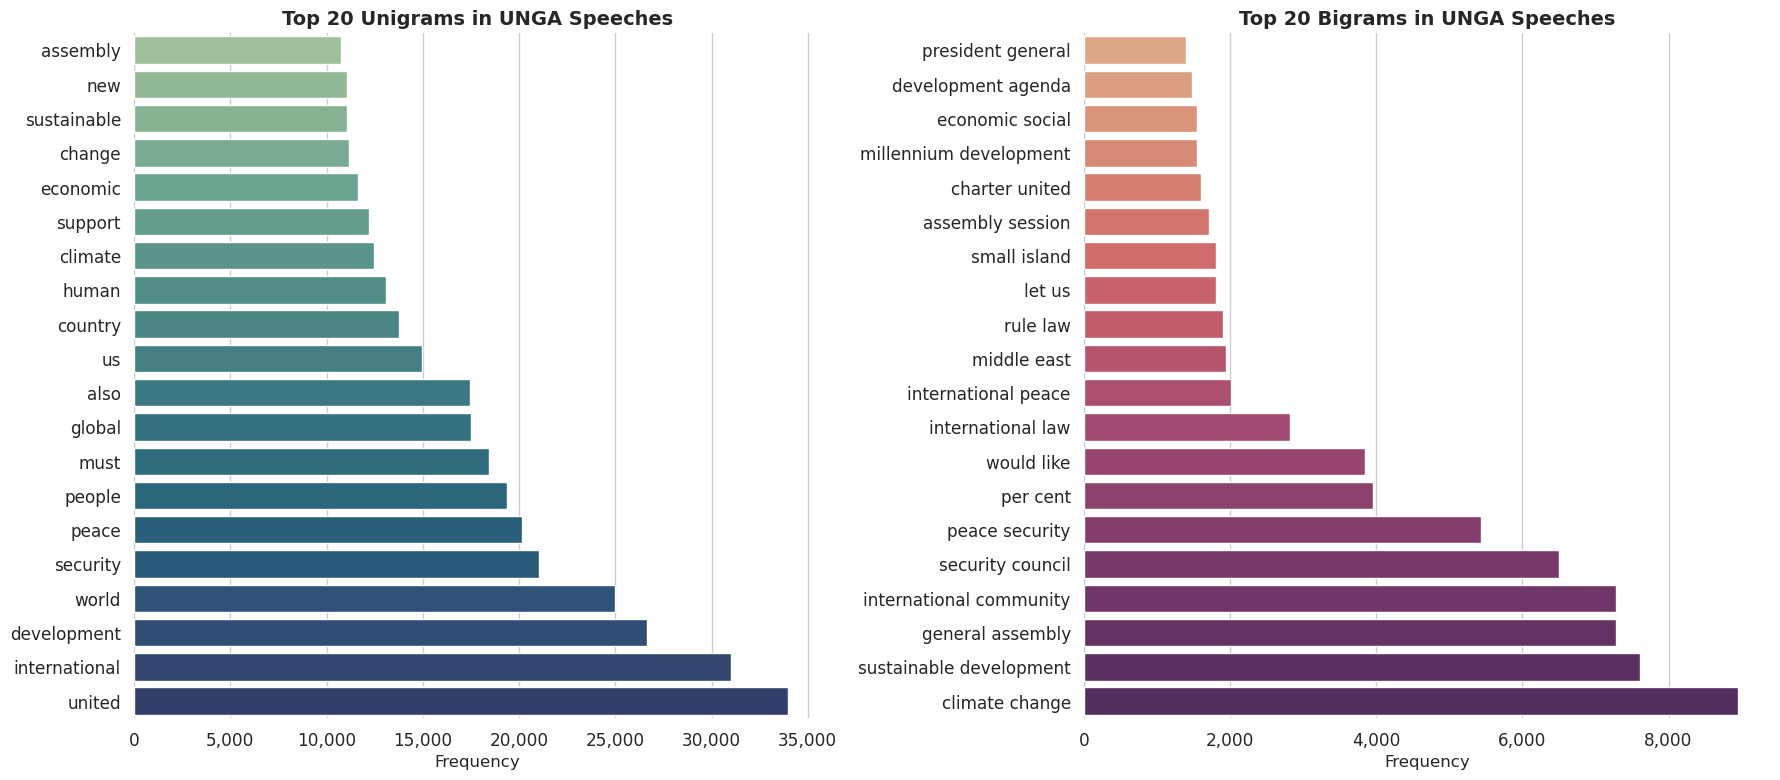

In [133]:
from collections import Counter
from nltk import ngrams
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
# Unigram counts
all_unigrams = []
for tokens in df_tokenize["speech_token"]:
    if isinstance(tokens, list):
        all_unigrams.extend(tokens)

unigram_counts = Counter(all_unigrams)
unigram_df = pd.DataFrame(unigram_counts.most_common(20), columns=["unigram", "count"])

# Bigram counts 
all_bigrams = []
for tokens in df_tokenize["speech_token"]:   
    if isinstance(tokens, list):
        all_bigrams.extend(list(ngrams(tokens, 2)))

bigram_counts = Counter(all_bigrams)
bigram_df = pd.DataFrame(bigram_counts.most_common(20), columns=["bigram", "count"])
bigram_df["bigram"] = bigram_df["bigram"].apply(lambda x: " ".join(x))

# Plot side by side 
sns.set_theme(style="whitegrid", font_scale=1.1)

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=False)

# Unigrams
sns.barplot(
    data=unigram_df.sort_values("count", ascending=True),
    y="unigram", x="count",
    hue="unigram", palette="crest", legend=False, ax=axes[0]
)
axes[0].set_title("Top 20 Unigrams in UNGA Speeches", fontsize=14, weight="bold")
axes[0].set_xlabel("Frequency", fontsize=12)
axes[0].set_ylabel("")
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Bigrams
sns.barplot(
    data=bigram_df.sort_values("count", ascending=True),
    y="bigram", x="count",
    hue="bigram", palette="flare", legend=False, ax=axes[1]
)
axes[1].set_title("Top 20 Bigrams in UNGA Speeches", fontsize=14, weight="bold")
axes[1].set_xlabel("Frequency", fontsize=12)
axes[1].set_ylabel("")
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))

# remove spines
for ax in axes:
    sns.despine(ax=ax, left=True, bottom=True)

plt.tight_layout()
plt.show()

## Import Political Polarization Dataset 

In [134]:
polarization_df = pd.read_csv("political-polarization-score.csv")
polarization_df.head()

polarization_df.columns = polarization_df.columns.str.lower()

bounds = [ -3, -1, 1, 3]

labels = [
    "Stable",
    "Neutral",
    "Polarized"
]

polarization_df["polarization label"] = pd.cut(
    polarization_df["political polarization score (central estimate)"],
    bins=bounds,
    labels=labels,
    include_lowest=True,
    right=False
)
polarization_df = polarization_df.rename(columns={"code": "country"})


polarization_df

,entity,country,year,political polarization score (central estimate),polarization label
0,Afghanistan,AFG,1992,2.775,Polarized
1,Afghanistan,AFG,1993,2.775,Polarized
2,Afghanistan,AFG,1994,2.775,Polarized
3,Afghanistan,AFG,1995,2.775,Polarized
4,Afghanistan,AFG,1996,2.775,Polarized
...,...,...,...,...,...
22674,Zimbabwe,ZWE,2020,2.499,Polarized
22675,Zimbabwe,ZWE,2021,2.066,Polarized
22676,Zimbabwe,ZWE,2022,1.551,Polarized
22677,Zimbabwe,ZWE,2023,1.984,Polarized


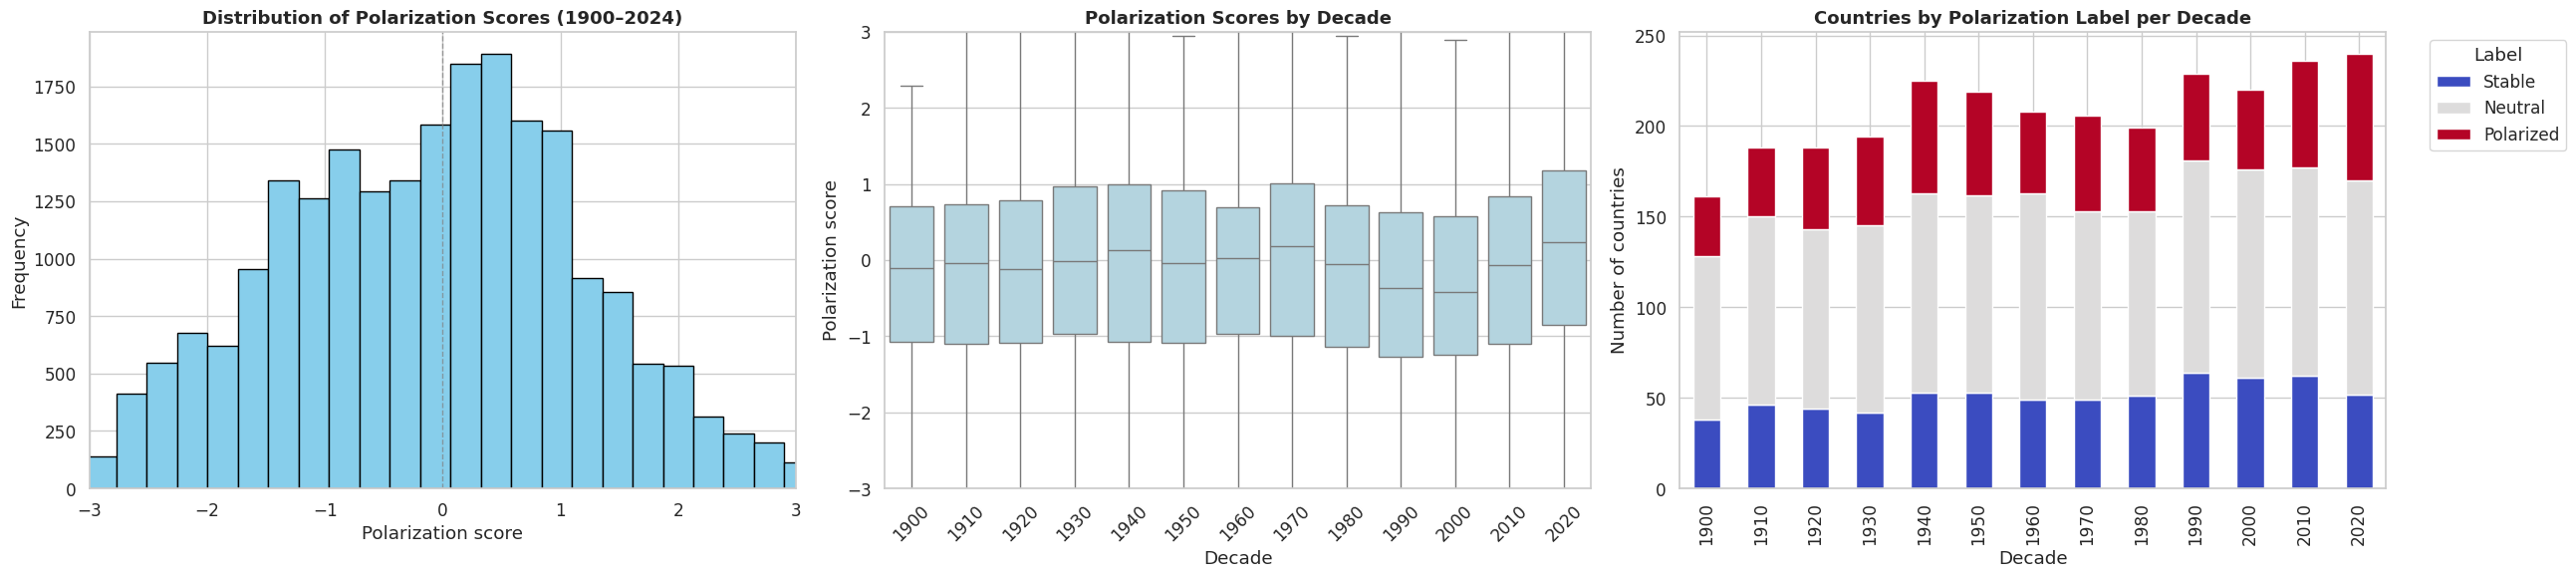

In [135]:
# Clean & prep
pol = polarization_df.copy()
pol = pol.dropna(subset=["political polarization score (central estimate)"])
pol["decade"] = (pol["year"] // 10) * 10
pol["decade"] = pol["decade"].astype(int)

# Count number of countries per label per decade
counts = (pol.groupby(["decade", "polarization label"], observed=True)["country"]
            .nunique()
            .reset_index(name="num_countries"))

# Pivot for stacked bar plotting
counts_pivot = counts.pivot(index="decade", columns="polarization label", values="num_countries").fillna(0)

# Create subplots: Histogram + Boxplot + Stacked Bar
fig, axes = plt.subplots(1, 3, figsize=(26, 6))

# 1) Histogram [-3, 3]
axes[0].hist(
    pol["political polarization score (central estimate)"],
    bins=30, edgecolor="black", color="skyblue"
)
axes[0].set_title("Distribution of Polarization Scores (1900–2024)", fontsize=13, weight="bold")
axes[0].set_xlabel("Polarization score")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(-3, 3)
axes[0].axvline(0, ls="--", lw=1, color="gray", alpha=0.7)

# 2) Boxplot by decade 
sns.boxplot(
    data=pol,
    x="decade",
    y="political polarization score (central estimate)",
    color="lightblue",
    ax=axes[1]
)
axes[1].set_title("Polarization Scores by Decade", fontsize=13, weight="bold")
axes[1].set_xlabel("Decade")
axes[1].set_ylabel("Polarization score")
axes[1].set_ylim(-3, 3)
axes[1].tick_params(axis='x', rotation=45)

# 3) Stacked bar: country counts by label & decade
counts_pivot.plot(
    kind="bar",
    stacked=True,
    ax=axes[2],
    colormap="coolwarm"
)
axes[2].set_title("Countries by Polarization Label per Decade", fontsize=13, weight="bold")
axes[2].set_xlabel("Decade")
axes[2].set_ylabel("Number of countries")
axes[2].legend(title="Label", bbox_to_anchor=(1.05, 1), loc="upper left")

# Final layout
plt.tight_layout()
plt.show()


## Merge Speeches with Polarisation Dataset

In [136]:
for df in (df_tokenize, polarization_df):
    df['country'] = df['country'].astype(str).str.strip()
    df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

bad_tf = df_tokenize[df_tokenize['year'].isna()]
bad_pol = polarization_df[polarization_df['year'].isna()]

##merge on right so that we filter out UN countries with missing polarisation scores
merged_df = df_tokenize.merge(
    polarization_df,
    how='right',
    on=['country', 'year']
)
merged_df = merged_df.dropna()
merged_df
dfwithspeeech = merged_df.copy()


# b) Data Analysis and Visualisation

## Exploring polarization intensity per country over the years 

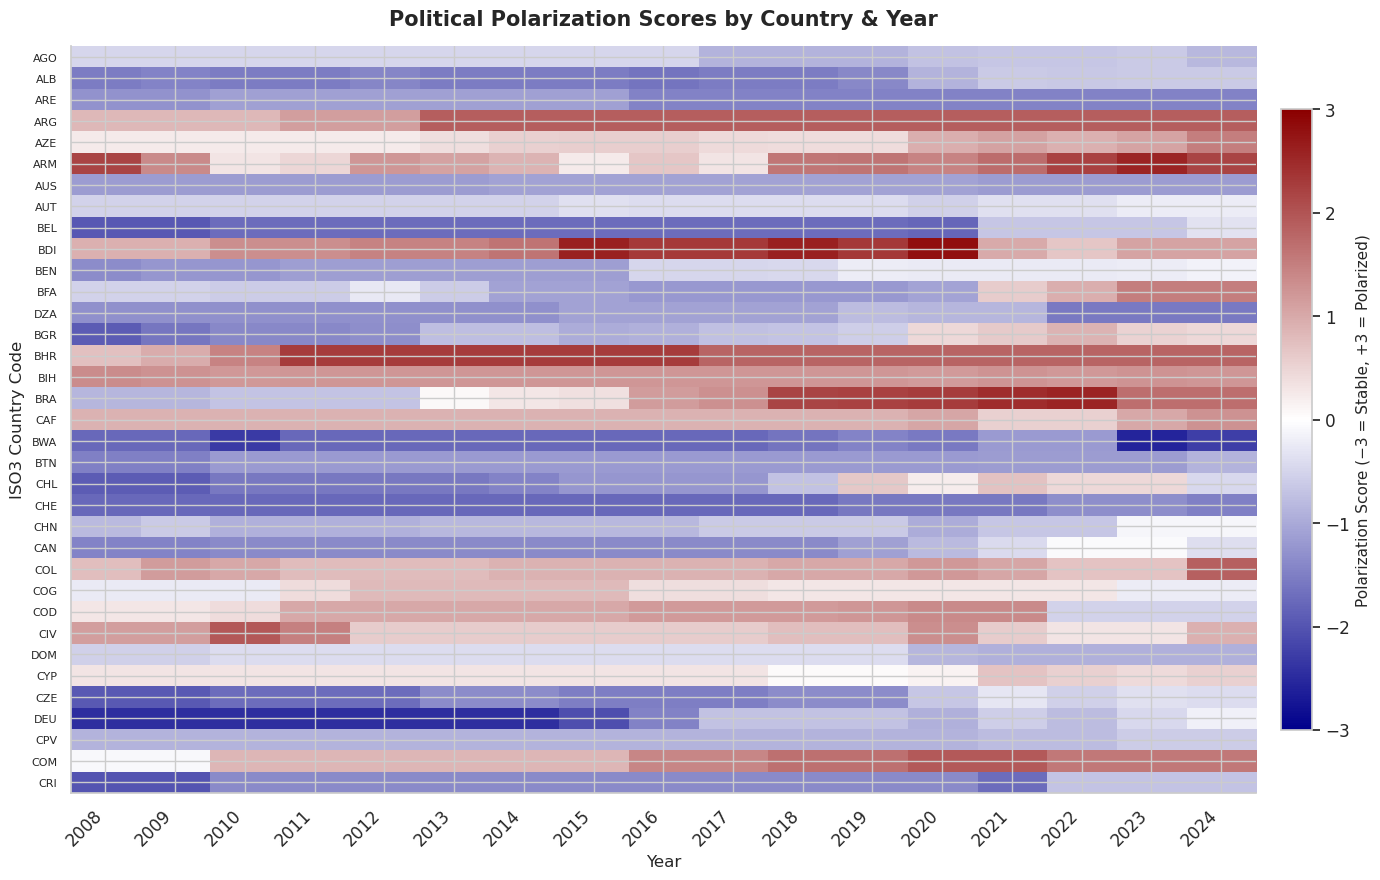

In [137]:
# Political polarization scores by country & year 
from matplotlib.colors import LinearSegmentedColormap

# Use all rows (keep NaNs for visualization)
df_all = merged_df.copy()

# Pick top N countries by number of available scores
topN = 35
top_codes = (df_all.groupby("country")["political polarization score (central estimate)"]
             .count().sort_values(ascending=False).head(topN).index.tolist())

sub = df_all[df_all["country"].isin(top_codes)]
years = np.arange(sub["year"].min(), sub["year"].max() + 1)

# Build matrix: countries × years
M = np.full((len(top_codes), len(years)), np.nan)
country_index = {c: i for i, c in enumerate(top_codes)}
year_index    = {y: i for i, y in enumerate(years)}

for _, r in sub.iterrows():
    i = country_index[r["country"]]
    j = year_index.get(r["year"])
    if j is not None:
        M[i, j] = r["political polarization score (central estimate)"]

# Mask NaNs so they can be styled separately
masked_M = np.ma.masked_invalid(M)

# Format
colors = ["darkblue", "white", "darkred"]
cmap = LinearSegmentedColormap.from_list("custom_div", colors, N=256)
cmap.set_bad(color="lightgray")  # missing values as light gray

# Plot
fig, ax = plt.subplots(figsize=(14, 9))

im = ax.imshow(
    masked_M,
    aspect="auto",
    interpolation="nearest",
    cmap=cmap,
    vmin=-3, vmax=3  # enforce theoretical score range
)

# Axis formatting
ax.set_yticks(range(len(top_codes)))
ax.set_yticklabels(top_codes, fontsize=8)

step = max(1, len(years)//15)
ax.set_xticks(range(0, len(years), step))
ax.set_xticklabels(years[::step], rotation=45, ha="right")

ax.set_title("Political Polarization Scores by Country & Year", fontsize=15, weight="bold", pad=15)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("ISO3 Country Code", fontsize=12)

# Colorbar with clear labels
cbar = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.02)
cbar.set_label("Polarization Score (−3 = Stable, +3 = Polarized)", fontsize=11)

# Styling
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


## Speech Style using TF-IDF 
The following code calculates the TF-IDF score for each word in every speech, this is then stored in the Dataframe as a list of pairs, containing (word, tf-idf score), sorted descendingly, so you get the higher TF-IDF scores first. 

It also considers bi-grams.

https://www.geeksforgeeks.org/machine-learning/understanding-tf-idf-term-frequency-inverse-document-frequency/

In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_tf_idf = merged_df.copy()

# Join tokens back into strings 
# we can also alternatively use df_tf_idf['speech_token'] = df_tf_idf['speech_token'].str.join(' '); however in order to avoid run-time errors , we use the lambda function
df_tf_idf['speech_token'] = df_tf_idf['speech_token'].apply(
    lambda x: ' '.join(x) if isinstance(x, list) else str(x)
)

speeches = df_tf_idf['speech_token']

# add n-grams (unigrams and bigrams) + frequency filters
tfidf_vector = TfidfVectorizer(
    ngram_range=(1, 2), # unigrams + bigrams
    min_df=2,
    max_df=0.9
)

tf_idf_matrix  = tfidf_vector.fit_transform(speeches)

print(tf_idf_matrix)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2645921 stored elements and shape (2802, 254122)>
  Coords	Values
  (0, 202730)	0.02188797739426906
  (0, 122293)	0.05043213405418349
  (0, 224295)	0.01771933573527489
  (0, 97740)	0.03262941863243559
  (0, 100156)	0.021296073712013776
  (0, 252612)	0.028623359045120426
  (0, 97671)	0.02206040949373126
  (0, 95142)	0.04715574465395888
  (0, 105239)	0.008511721628037061
  (0, 1362)	0.03893179040060577
  (0, 211995)	0.03082761095464235
  (0, 104622)	0.0291572105987865
  (0, 15487)	0.04139735901873387
  (0, 99072)	0.050253018439023994
  (0, 233017)	0.017946491249994583
  (0, 33438)	0.009370862854551937
  (0, 30495)	0.008821262828669463
  (0, 184912)	0.014878938455604713
  (0, 198447)	0.03383720983540404
  (0, 137680)	0.04984245312325676
  (0, 201552)	0.07087153122013705
  (0, 86476)	0.027585830284591027
  (0, 132456)	0.02809198553718488
  (0, 63021)	0.052344482084409893
  (0, 25639)	0.02585320456713798
  :	:
  (2801, 250132)	0.

In [139]:
feature_names = tfidf_vector.get_feature_names_out()

def matrix_to_tfidf_pairs(row):
    row_array = row.toarray().flatten()  
    word_tf_idf_pairs = [(word, score) for word, score in zip(feature_names, row_array) if score > 0]
    pairs_sorted = sorted(word_tf_idf_pairs, key=lambda x: x[1], reverse=True)
    return pairs_sorted

df_tf_idf['speech_score'] = [matrix_to_tfidf_pairs(tf_idf_matrix[i]) for i in range(tf_idf_matrix.shape[0])]

df_tf_idf[['country', 'year', 'speech_score']].head()

,country,year,speech_score
16,AFG,2008,"[(shortage food, 0.10972646886458641), (terror..."
17,AFG,2009,"[(comprehensive strategy, 0.1172748129445414),..."
18,AFG,2010,"[(jirga, 0.19029964624348292), (allies, 0.0948..."
19,AFG,2011,"[(transition, 0.1202605842757524), (high peace..."
20,AFG,2012,"[(violence, 0.09841193080173656), (high peace,..."


## Rhetorical Differences Between Stable and Unrest Countries  

In this section, we investigate whether countries experiencing higher domestic unrest (Polarized) use measurably different rhetoric in their UNGA speeches compared to politically stable countries.  

To do this, we:  
1. Split speeches into **Stable** vs **Unrest** groups based on the polarization label.  
2. Compute average TF-IDF scores for each word across the two groups.  
3. Identify and visualize the words that are most characteristic of **Unrest** versus **Stable** countries.  

This step directly addresses the **exploratory question** by highlighting how rhetoric differs between politically stable nations and those facing domestic unrest.  


##  Is domestic unrest associated with distinct rheotoric patterns in UNGC speeches? Specifically, do countries experiencing high unrest employ different rhetorical patterns compared to stable countries?

The helper function top_terms() sorts by the largest differences in TF-IDF between groups.

- If delta > 0: word is emphasized more in polarized/unrest speeches.
- If delta < 0: word is emphasized more in stable speeches.

In [140]:
# Filtering relevant groups and creating group masks
keep = df_tf_idf['polarization label'].isin(["Stable", "Polarized"])
df_tf_idf_filtered = df_tf_idf.loc[keep].reset_index(drop=True)
tf_idf_matrix_filtered = tf_idf_matrix[keep.values]  # subset matrix to match

mask_unrest = df_tf_idf_filtered["polarization label"].eq("Polarized").values
mask_stable = df_tf_idf_filtered["polarization label"].eq("Stable").values

# Compute mean TF-IDF by group
mean_unrest = tf_idf_matrix_filtered[mask_unrest].mean(axis=0).A1
mean_stable = tf_idf_matrix_filtered[mask_stable].mean(axis=0).A1
delta = mean_unrest - mean_stable  # positive = unrest-leaning; delta shows which words/bigrams are more emphasized in polarized (unrest) vs stable contexts.

fn = np.array(feature_names)

# feature separation
is_bigram  = np.array([" " in t for t in fn])
is_unigram = ~is_bigram

def top_terms(delta_vec, feats, k=15, mask=None, reverse=False):
    idx = np.arange(len(delta_vec))
    if mask is not None: idx = idx[mask]
    order = idx[np.argsort(delta_vec[idx])]
    if not reverse: order = order[::-1]
    return [(feats[i], float(delta_vec[i])) for i in order[:k]]

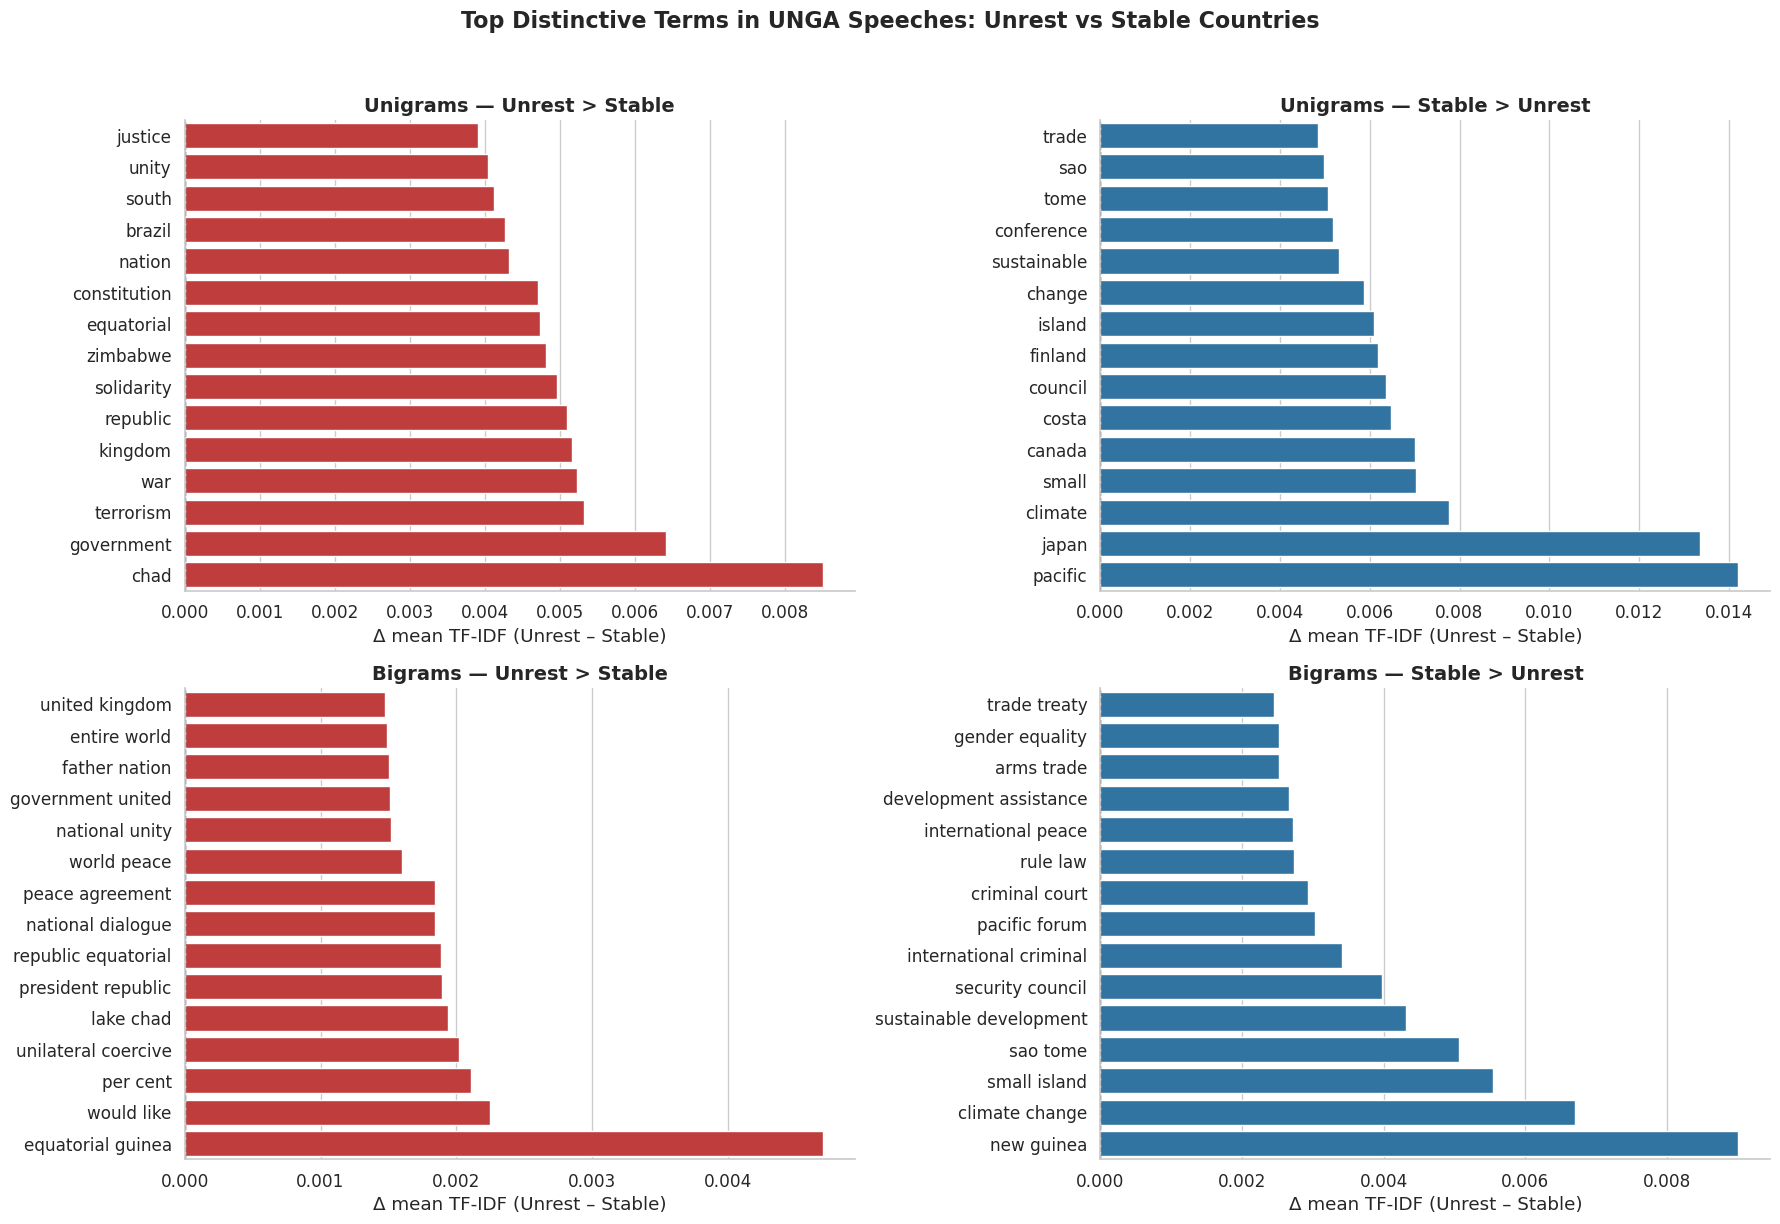

In [141]:
# Barplots: Top delta TF-IDF Terms (Unrest vs Stable) 
import seaborn as sns
import matplotlib.pyplot as plt

# Build DataFrames of the top delta terms for plotting
def top_df(delta_vec, feats, k=15, mask=None, sign=+1, tag="Unrest"):
    idx = np.arange(len(delta_vec))
    if mask is not None:
        idx = idx[mask]
    # sign=+1 : top Unrest (largest positive deltas)
    # sign=-1 : top Stable (largest negative deltas)
    order = idx[np.argsort(sign * delta_vec[idx])][::-1][:k]
    return pd.DataFrame({
        "term": feats[order],
        "delta": delta_vec[order] * sign, # positive values for plotting
        "side": tag
    })

top_uni_unrest = top_df(delta, fn, k=15, mask=is_unigram, sign=+1, tag="Unrest")
top_uni_stable = top_df(delta, fn, k=15, mask=is_unigram, sign=-1, tag="Stable")
top_bi_unrest  = top_df(delta, fn, k=15, mask=is_bigram,  sign=+1, tag="Unrest")
top_bi_stable  = top_df(delta, fn, k=15, mask=is_bigram,  sign=-1, tag="Stable")

# Set style
sns.set_theme(style="whitegrid", font_scale=1.1)

# Plot 2×2 barh
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

def barh(ax, df, title, color):
    df_plot = df.sort_values("delta") # ascending for clean ordering
    sns.barplot(
        data=df_plot,
        x="delta", y="term",
        color=color,
        ax=ax
    )
    ax.axvline(0, color="black", lw=1, ls="--", alpha=0.7) # reference line
    ax.set_title(title, fontsize=14, weight="bold")
    ax.set_xlabel("Δ mean TF-IDF (Unrest – Stable)")
    ax.set_ylabel("")
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

# Apply plotting function with distinct colors
barh(axes[0], top_uni_unrest, "Unigrams — Unrest > Stable", "#d62728") # red
barh(axes[1], top_uni_stable, "Unigrams — Stable > Unrest", "#1f77b4") # blue
barh(axes[2], top_bi_unrest,  "Bigrams — Unrest > Stable", "#d62728") # red 
barh(axes[3], top_bi_stable,  "Bigrams — Stable > Unrest", "#1f77b4") # blue 

plt.suptitle("Top Distinctive Terms in UNGA Speeches: Unrest vs Stable Countries", 
             fontsize=16, weight="bold", y=1.02)

plt.tight_layout()
plt.show()

Each barplot compares **average TF-IDF scores** of words/phrases between two groups of countries:
- **Polarized (Unrest)** countries  
- **Stable** countries  

For each unigram (single word) or bigram (two-word phrase), we compute: Δ = {mean TF-IDF in Unrest speeches} - {mean TF-IDF in Stable speeches}
 

### Interpreting each subplot

**Unigrams — Unrest > Stable**  
- Shows the top single words where Δ is **positive**.  
- These words are used relatively more often (or emphasized more strongly) in speeches by **polarized/unrest countries** compared to stable countries.  

**Unigrams — Stable > Unrest**  
- Shows the top single words where Δ is **negative** (but flipped to positive for visualization).  
- These words are used relatively more often in speeches by **stable countries** compared to unrest countries.  

**Bigrams — Unrest > Stable**  
- Same as above, but for **two-word phrases**.  
- Tells you which bigrams are most distinctive of **polarized contexts**.  

**Bigrams — Stable > Unrest**  
- Same as above, but for bigrams.  
- Tells you which bigrams are most distinctive of **stable contexts**.  


## Performing statistical test to prove our evidence-backed hypothesis

To assess whether specific words are systematically emphasized differently between **polarized (unrest)** and **stable** countries, we applied a **non-parametric statistical framework** on TF–IDF features.

### Method
1. **Effect Size (Δ TF–IDF):**
   - Computed the difference in mean TF–IDF scores:
     - Δ > 0 → term more common in **Polarized** speeches.
     - Δ < 0 → term more common in **Stable** speeches.

2. **Significance Testing:**
   - For each term, we applied the **Mann–Whitney U test**, a non-parametric test comparing the distribution of TF–IDF scores across the two groups.
   - This is preferable to a t-test since TF–IDF distributions are non-normal and highly skewed.

3. **Multiple Testing Correction:**
   - Because many terms are tested simultaneously, raw p-values (`p_raw`) risk inflated false positives.
   - We applied the **Benjamini–Hochberg False Discovery Rate (FDR)** procedure to obtain adjusted p-values (`p_fdr`).

In [142]:
from scipy.stats import mannwhitneyu

fn = np.array(feature_names)
X = tf_idf_matrix_filtered # sparse csr

# pick features with largest absolute deltas
mean_unrest = X[mask_unrest].mean(axis=0).A1
mean_stable = X[mask_stable].mean(axis=0).A1
delta = mean_unrest - mean_stable
k = min(200, len(delta))
top_idx = np.argsort(np.abs(delta))[::-1][:k]

rows = []
Xu = X[mask_unrest][:, top_idx].toarray()
Xs = X[mask_stable][:, top_idx].toarray()

for j, col in enumerate(top_idx):
    u = Xu[:, j]
    s = Xs[:, j]
    # nonparametric 2-sample test
    stat, p = mannwhitneyu(u, s, alternative="two-sided")
    rows.append([fn[col], delta[col], p])

res = pd.DataFrame(rows, columns=["term","delta","p_raw"]).sort_values("p_raw")

# Benjamini–Hochberg FDR
m = len(res)
res = res.sort_values("p_raw").reset_index(drop=True)
res["rank"] = np.arange(1, m+1)
res["p_fdr"] = res["p_raw"] * m / res["rank"]
res["p_fdr"] = res["p_fdr"].clip(upper=1.0)

print(res.head(20)) # most significant differences
print((res["p_fdr"]<0.05).mean(), "share of tested terms significant at FDR<0.05")


                      term     delta         p_raw  rank         p_fdr
0             small island -0.005545  3.197967e-17     1  6.395933e-15
1           climate change -0.006700  1.309128e-15     2  1.309128e-13
2             trade treaty -0.002451  1.675103e-14     3  1.116735e-12
3               conference -0.005190  3.720110e-13     4  1.860055e-11
4                   island -0.006098  3.876363e-13     5  1.550545e-11
5               arms trade -0.002523  4.855555e-13     6  1.618518e-11
6             constitution  0.004709  1.344383e-12     7  3.841093e-11
7           criminal court -0.002935  1.700100e-12     8  4.250250e-11
8                    unity  0.004042  1.744081e-12     9  3.875736e-11
9                  climate -0.007761  2.066238e-12    10  4.132476e-11
10                   small -0.007041  2.444232e-12    11  4.444058e-11
11           pacific forum -0.003032  5.048951e-12    12  8.414919e-11
12                  change -0.005880  7.178579e-12    13  1.104397e-10
13    

### Columns in the Results
- **term** : unigram or bigram being tested.  
- **delta** : mean TF–IDF difference between groups (Polarized – Stable).  
- **p_raw** : raw Mann–Whitney U test p-value.  
- **rank** : ordering of terms from most to least significant (based on `p_raw`).  
- **p_fdr** : FDR-adjusted p-value; terms with `p_fdr < 0.05` are considered statistically significant. This ensures that, across all terms declared significant, fewer than 5% are expected to be false positives.  


### Findings
- **200 terms** (largest |Δ|) were tested.  
- **95.5% (≈191 terms)** remain significant at **FDR < 0.05**.  
- **Unrest-leaning terms (Δ > 0):** *imperialist, socialist, sovereignty, struggle, unity* : words tied to conflict, ideology, and power.  
- **Stable-leaning terms (Δ < 0):** *criminal court, arms control, pacific forum, member* : words emphasizing institutions, cooperation, and procedures.  

### Interpretation
These results show strong evidence that **political unrest systematically shifts rhetorical focus** in UNGA speeches:  
- **Polarized countries** highlight *conflictual, ideological, and power-charged language*.  
- **Stable countries** stress *institutional, cooperative, and procedural language*.  

Given that **95.5% of tested terms were significant at FDR < 0.05**, we can be highly confident that these observed rhetorical differences are not due to chance. This offers robust quantitative support for the hypothesis that **domestic instability is mirrored in international speech rhetoric**.

The results provide strong evidence that **speech rhetoric systematically differs between polarized and stable societies**, supporting the exploratory claim that unrest is associated with distinct rhetorical patterns.

## Plots to visualise

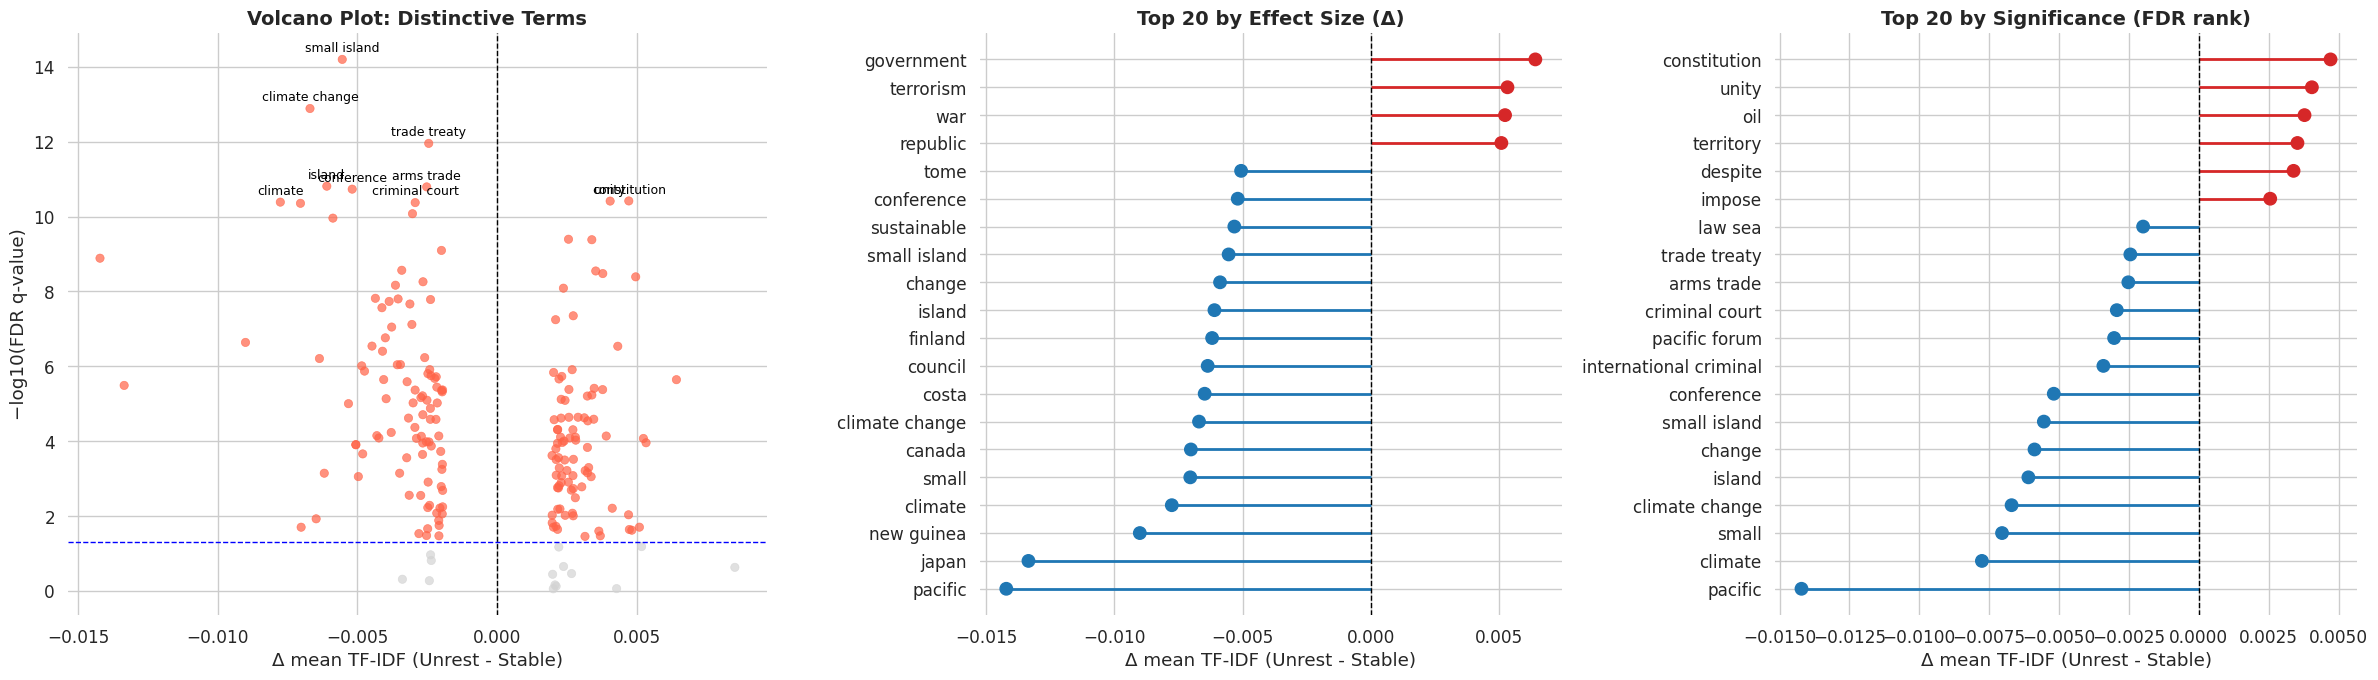

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure clean copy
df = res.copy()
df["neglogq"] = -np.log10(df["p_fdr"].replace(0, 1e-300))

# Parameters
alpha_q = 0.05
top_k = 20

# Volcano + two lollipop charts
fig, axes = plt.subplots(1, 3, figsize=(24,7), gridspec_kw={'width_ratios':[1.2,1,1]})

# 1) Volcano
ax = axes[0]
sns.scatterplot(
    data=df, x="delta", y="neglogq",
    hue=df["p_fdr"] < alpha_q,
    palette={True: "tomato", False: "lightgray"},
    alpha=0.7, edgecolor=None, ax=ax, legend=False
)

ax.axvline(0, color="black", ls="--", lw=1)
ax.axhline(-np.log10(alpha_q), color="blue", ls="--", lw=1)

ax.set_title("Volcano Plot: Distinctive Terms", fontsize=14, weight="bold")
ax.set_xlabel("Δ mean TF-IDF (Unrest - Stable)")
ax.set_ylabel("−log10(FDR q-value)")

# Annotate top significant terms (by FDR)
top = df.nsmallest(10, "p_fdr")
for _, row in top.iterrows():
    ax.text(row["delta"], row["neglogq"]+0.2, row["term"],
            fontsize=9, ha="center", color="black")

# 2) Lollipop by Effect Size (delta)
ax = axes[1]
top_delta = df.loc[df["p_fdr"] < alpha_q].reindex(
    df.loc[df["p_fdr"] < alpha_q, "delta"].abs().sort_values(ascending=False).index
).head(top_k)

top_delta = top_delta.sort_values("delta")

colors = top_delta["delta"].apply(lambda x: "#d62728" if x > 0 else "#1f77b4")

ax.hlines(y=top_delta["term"], xmin=0, xmax=top_delta["delta"],
          color=colors, lw=2)
ax.scatter(top_delta["delta"], top_delta["term"],
           color=colors, s=80, zorder=3)

ax.axvline(0, color="black", lw=1, ls="--")
ax.set_title(f"Top {top_k} by Effect Size (Δ)", fontsize=14, weight="bold")
ax.set_xlabel("Δ mean TF-IDF (Unrest - Stable)")
ax.set_ylabel("")

# 3) Lollipop by Significance (Rank p_fdr) 
ax = axes[2]
top_sig = df.loc[df["p_fdr"] < alpha_q].nsmallest(top_k, "p_fdr")

top_sig = top_sig.sort_values("delta")
colors = top_sig["delta"].apply(lambda x: "#d62728" if x > 0 else "#1f77b4")

ax.hlines(y=top_sig["term"], xmin=0, xmax=top_sig["delta"],
          color=colors, lw=2)
ax.scatter(top_sig["delta"], top_sig["term"],
           color=colors, s=80, zorder=3)

ax.axvline(0, color="black", lw=1, ls="--")
ax.set_title(f"Top {top_k} by Significance (FDR rank)", fontsize=14, weight="bold")
ax.set_xlabel("Δ mean TF-IDF (Unrest - Stable)")
ax.set_ylabel("")

# Styling
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

- **Volcano plot (left):**  
  Each dot is a unigram or bigram.  
  - **x-axis**: effect size (Δ mean TF–IDF between Unrest and Stable speeches).  
  - **y-axis**: significance (−log10 of the FDR-adjusted p-value).  
  - **Red points** = statistically significant differences at q < 0.05.  
  - Labels highlight the most statistically significant terms.  

- **Lollipop chart (middle, by effect size):**  
  Focuses on the **top 20 significant terms** with the **largest absolute differences (Δ)**.  
  - **Red bars** → terms more prevalent in Unrest contexts.  
  - **Blue bars** → terms more prevalent in Stable contexts.  
  - Highlights **which terms show the strongest rhetorical contrasts**, regardless of how consistent the difference is.  

- **Lollipop chart (right, by significance):**  
  Focuses on the **top 20 terms ranked by FDR-adjusted p-values (statistical significance)**.  
  - **Red bars** → terms more prevalent in Unrest contexts.  
  - **Blue bars** → terms more prevalent in Stable contexts.  
  - Highlights **which terms are most reliably different across groups**, even if the effect size is smaller.  


### Why include both perspectives?
- **Effect size (Δ)** → shows *how big* the rhetorical difference is. Large Δ terms are the most distinctive. 
  - "Which terms differ the most in rhetoric?” 
- **Significance (FDR rank)** → shows *how consistent* the difference is across many speeches. 
  -  "Which terms differ most reliably across countries/years?”

Together, these three plots provide a **complementary view**:  
- Volcano = broad global overview.  
- Lollipop Δ = terms with the **strongest rhetorical separation**.  
- Lollipop significance = terms with the **strongest statistical evidence** of difference.  


# How are these rhetorical differences related to levels of national happiness?

### Import Happiness Dataset

In [144]:
happinessdataframe = pd.read_excel('DataForTable2.1.xls')

### Exploring the World Happiness Dataset
Before merging happiness scores with UNGA speeches and polarization data, we first clean and explore the World Happiness Report dataset.

- We focus on the **Life Ladder** variable (0–10 scale), which reflects self-reported life satisfaction.  
- After dropping missing values, we confirm coverage across multiple decades and countries.  
- Exploratory plots show the distribution of Life Ladder, global time trends, and which countries consistently rank highest and lowest in happiness.  

This step ensures the dataset is consistent and interpretable before integration with rhetorical and polarization measures.


Shape after cleaning: (2363, 11)
Years covered: 2005 - 2023
Unique countries: 165


count    2363.000000
mean        5.483562
std         1.125523
min         1.281271
25%         4.646750
50%         5.448725
75%         6.323592
max         8.018934
Name: Life Ladder, dtype: float64

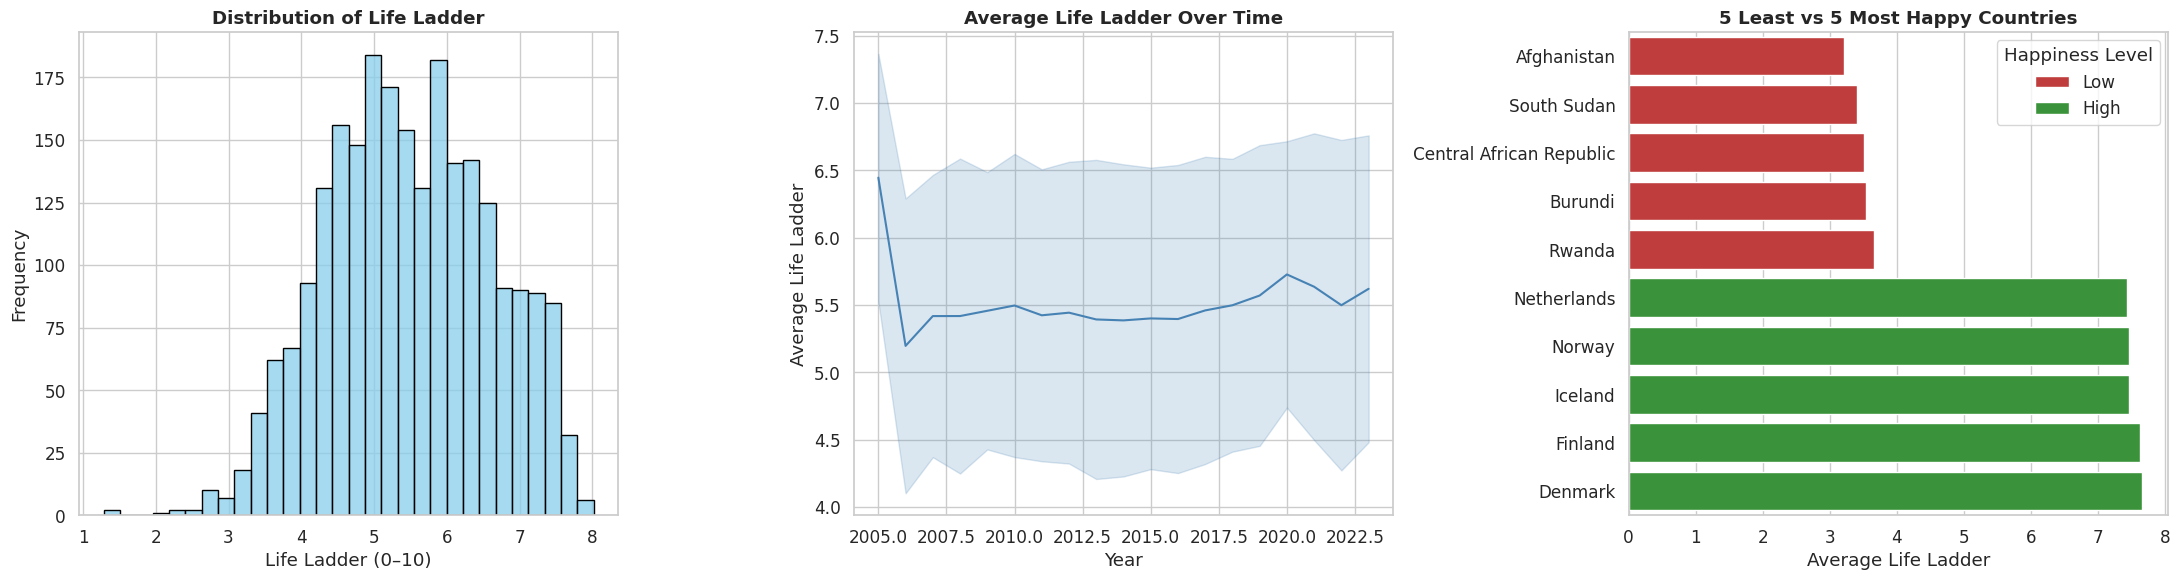

In [145]:
# Exploratory Analysis: World Happiness Data 

import seaborn as sns
import matplotlib.pyplot as plt

# Clean
happiness = happinessdataframe.copy()
happiness = happiness.rename(columns={"Country name": "country"})
happiness = happiness.dropna(subset=["Life Ladder"])
happiness["year"] = happiness["year"].astype(int)

# Summary info
print("Shape after cleaning:", happiness.shape)
print("Years covered:", happiness['year'].min(), "-", happiness['year'].max())
print("Unique countries:", happiness['country'].nunique())
display(happiness['Life Ladder'].describe())

# Create side-by-side plots 
sns.set_theme(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(1, 3, figsize=(22,6))

# 1) Histogram
sns.histplot(happiness["Life Ladder"], bins=30, color="skyblue", edgecolor="black", ax=axes[0])
axes[0].set_title("Distribution of Life Ladder", weight="bold")
axes[0].set_xlabel("Life Ladder (0–10)")
axes[0].set_ylabel("Frequency")

# 2) Global trend over time
sns.lineplot(data=happiness, x="year", y="Life Ladder", errorbar="sd", color="steelblue", ax=axes[1])
axes[1].set_title("Average Life Ladder Over Time", weight="bold")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Average Life Ladder")

# 3) Top/Bottom countries (average)
avg_happiness = happiness.groupby("country")["Life Ladder"].mean().sort_values()
top_bottom = pd.concat([avg_happiness.head(5), avg_happiness.tail(5)])

sns.barplot(
    data=top_bottom.reset_index(),
    y="country", x="Life Ladder",
    hue=["Low"]*5 + ["High"]*5,
    dodge=False, palette={"Low":"#d62728","High":"#2ca02c"},
    ax=axes[2]
)
axes[2].set_title("5 Least vs 5 Most Happy Countries", weight="bold")
axes[2].set_xlabel("Average Life Ladder")
axes[2].set_ylabel("")
axes[2].legend(title="Happiness Level")

plt.tight_layout()
plt.show()


### Linking Rhetoric and Happiness

Our research question asked whether domestic unrest is reflected in UNGA rhetoric, and whether these rhetorical differences are related to national happiness.  
To address this, we look at:

2. **Sentiment Analysis × Happiness × Political polarization**  
   - Using the VADER sentiment analyzer, we evaluate whether happier countries also deliver more **positive-toned speeches**.  
   - This complements the RDI approach by focusing on **emotional tone**, not just rhetorical content.  


## 1. Sentiment Analysis
 This function computes an average sentiment score for each speech.  
 It analyzes sentences individually with VADER, takes the 5 most positive and 5 most negative scores,  
 and returns the average to capture both extremes of sentiment in the speech.  

In [165]:
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize


# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()
# Apply sentiment analysis to each speech
# print("hey",dfwithspeeech)


happinessdataframe = pd.read_excel('DataForTable2.1.xls')
happinessdataframe
happinesmergeddf = dfwithspeeech.merge(
    happinessdataframe,
    left_on=['entity', 'year'],
    right_on=['Country name', 'year'],
    how='inner'   # or 'outer' / 'left' depending on what you need
)

print(happinesmergeddf.head)
print(dfwithspeeech.head)
scaler = MinMaxScaler(feature_range=(-1, 1))

# Select the columns to be normalized
columns_to_normalize = ['political polarization score (central estimate)', 'Life Ladder']

print(happinesmergeddf.shape,dfwithspeeech.shape)
# Fit the scaler to the data and transform the columns
happinesmergeddf[columns_to_normalize] = scaler.fit_transform(happinesmergeddf[columns_to_normalize])

# Initialize the VADER analyzer
sia = SentimentIntensityAnalyzer()

# Assuming your DataFrame is named 'happinessmergeddf'
# and the column with speeches is named 'speech'

def get_average_sentiment(speech):
    """
    Calculates the average compound sentiment score for a given speech by
    analyzing it sentence by sentence.
    """
    # Check if the input is a valid string
    if not isinstance(speech, str) or not speech.strip():
        return 0.0  # Return a neutral score for empty or invalid input

    # Tokenize the speech into sentences
    sentences = sent_tokenize(speech)

    # If no sentences are found, return a neutral score
    if not sentences:
        return 0.0

    # Calculate the compound score for each sentence
    compound_scores = [sia.polarity_scores(sentence)['compound'] for sentence in sentences]
    compound_scores.sort()
    lowest = compound_scores[:5]      # first 5 elements
    highest = compound_scores[-5:]    # last 5 elements
# Combine them into a new variable (list)
    result = lowest + highest
    # Calculate the average of all compound scores
    average_score = sum(result) / len(result)
    return average_score

# Apply the function to the 'speech' column and create a new 'sentiment' column
happinesmergeddf['sentiment'] = happinesmergeddf['speech'].apply(get_average_sentiment)

# Print the final DataFrame with normalized values
print("DataFrame with normalized columns (range -1 to 1):")
# print(happinesmergeddf[columns_to_normalize])
columns_to_show = ['political polarization score (central estimate)', 'Life Ladder','country','sentiment']
happinesmergeddf[columns_to_show]

<bound method NDFrame.head of      country  year                                             speech  \
0        AFG  2008  Since the last time we \ngathered here in this...   
1        AFG  2009  First, I would like to \ncongratulate His Exce...   
2        AFG  2010  I join previous \nspeakers in congratulating y...   
3        AFG  2011  I am honoured to be \nhere to read the stateme...   
4        AFG  2012  ﻿As we speak today, the world\nis being shaken...   
...      ...   ...                                                ...   
1949     ZWE  2019  Allow me to congratulate Mr. Tijjani Muhammad-...   
1950     ZWE  2020  Your Excellency, Ambassador Volkan Bozkir, Pre...   
1951     ZWE  2021  Your Excellency Abdulla Shahid, President of t...   
1952     ZWE  2022  It is my singular honour to deliver this state...   
1953     ZWE  2023  I wish to congratulate Mr. Dennis Francis on h...   

                                           speech_token       entity  \
0     [since, last, t

,political polarization score (central estimate),Life Ladder,country,sentiment
0,-0.014689,-0.466589,AFG,-0.01629
1,-0.014689,-0.232411,AFG,0.02653
2,-0.014689,-0.109277,AFG,0.02074
3,-0.014689,-0.429252,AFG,0.00981
4,-0.014689,-0.446096,AFG,0.01052
...,...,...,...,...
1949,0.833868,-0.822270,ZWE,0.03904
1950,0.833868,-0.661264,ZWE,0.19619
1951,0.687658,-0.663068,ZWE,0.08295
1952,0.513760,-0.614159,ZWE,0.06196


Samples used: 1954
Pearson r: -0.0595

Linear regression:  Yi = intercept + slope * Xi
  intercept: 0.004705
  slope:     -0.374696
  R^2:       0.0035
  p-value:   0.00856607
  std_err:   0.142385


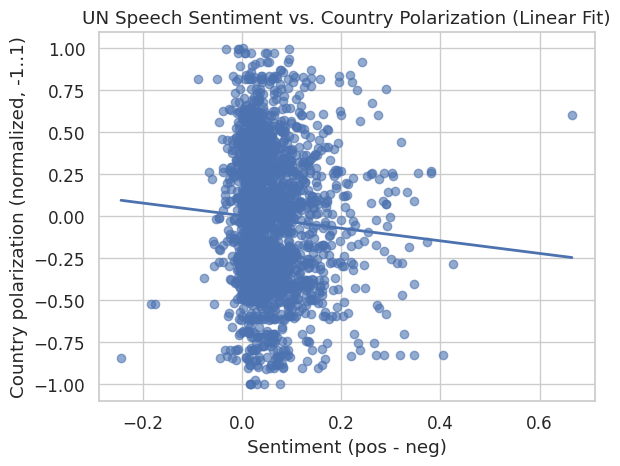

In [166]:
from scipy.stats import pearsonr, linregress

nltk_df = happinesmergeddf.copy()

# Reshape polarization from [-3,3] to [-1,1]
y = np.array(nltk_df["political polarization score (central estimate)"]).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaled = scaler.fit_transform(y)

nltk_df["political polarization score (central estimate)"] = y_scaled

# Regression code
Xi = nltk_df['sentiment'].values
Yi = nltk_df["political polarization score (central estimate)"].values

# Pearson linear regression
pearson_r, p_val = pearsonr(Xi, Yi)

# Simple linear regression Yi = a + b * Xi 
slope, intercept, r_value, p_value, std_err = linregress(Xi, Yi)

print(f"Samples used: {len(nltk_df)}")
print(f"Pearson r: {pearson_r:.4f}")
print("\nLinear regression:  Yi = intercept + slope * Xi")
print(f"  intercept: {intercept:.6f}")
print(f"  slope:     {slope:.6f}")
print(f"  R^2:       {r_value**2:.4f}")
print(f"  p-value:   {p_value:.6g}")
print(f"  std_err:   {std_err:.6f}")

#  Quick scatter + fitted line
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(Xi, Yi, alpha=0.6)
xline = np.linspace(Xi.min(), Xi.max(), 200)
yline = intercept + slope * xline
plt.plot(xline, yline, linewidth=2)
plt.xlabel("Sentiment (pos - neg)")
plt.ylabel("Country polarization (normalized, -1..1)")
plt.title("UN Speech Sentiment vs. Country Polarization (Linear Fit)")
plt.show()

## 2. Sentiment Analysis × Happiness × Political polarization
Apply the sentiment analysis to each speech in the merged dataset.  
A new 'sentiment' column is created in happinesmergeddf to store these scores.  


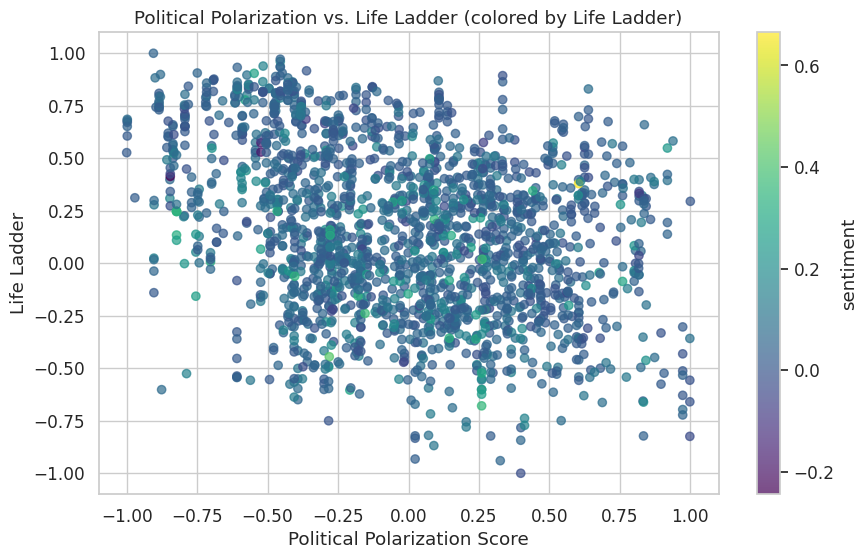

In [167]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'happinesmergeddf'
# And the columns are correctly named as in the image

# Plot: Political Polarization vs. Life Ladder, colored by Sentiment
plt.figure(figsize=(10, 6))
plt.scatter(
    happinesmergeddf['political polarization score (central estimate)'],
    happinesmergeddf['Life Ladder'],
    c=happinesmergeddf['sentiment'], # Use sentiment for color
    cmap='viridis',                  # Choose a color map
    alpha=0.7                        # Adjust transparency
)

# Add a color bar to explain the sentiment values
cbar = plt.colorbar()
cbar.set_label('sentiment')

# Set labels and title
plt.xlabel('Political Polarization Score')
plt.ylabel('Life Ladder')
plt.title('Political Polarization vs. Life Ladder (colored by Life Ladder)')

plt.grid(True)
plt.show()

# c) Model Selection and Validation

## Linear Regression - Lasso

https://scikit-learn.org/stable/modules/linear_model.html

In [149]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

Mean Squared Error: 0.1041540396828605
Mean Absolute Error: 0.26388234455328397
R^2 Score: 0.4571806158981261


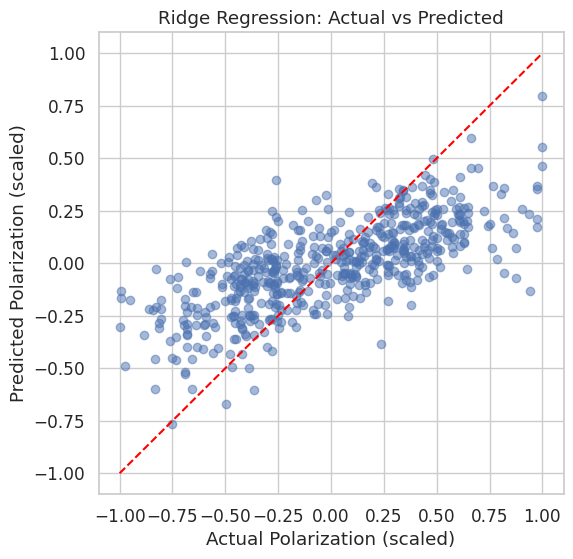

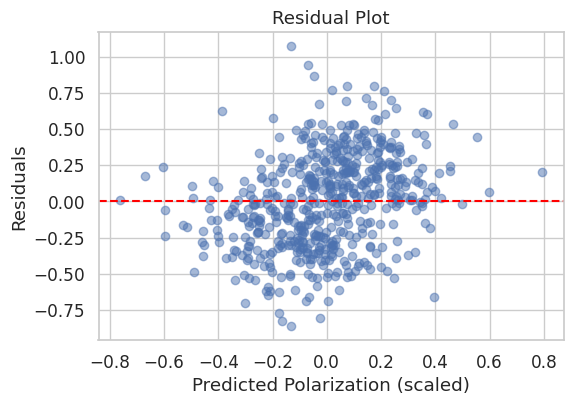

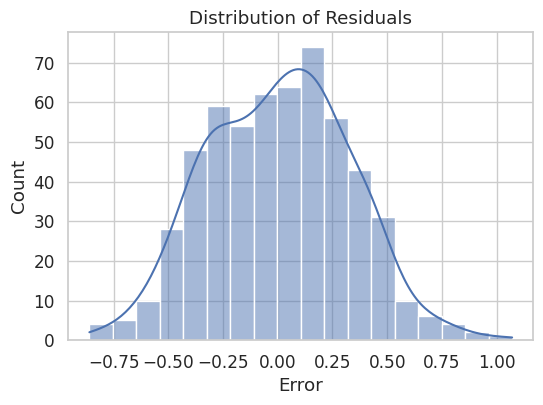

In [150]:
df_lin = merged_df.copy()
df_lin = df_lin.rename(columns={"political polarization score (central estimate)": "polarization score"})

y = np.array(df_lin["polarization score"]).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaled = scaler.fit_transform(y)

df_lin["polarization scaled"] = y_scaled


X = tf_idf_matrix
y = df_lin['polarization scaled']
# y = df_lin['polarization score']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_lin = linear_model.Ridge(alpha=0.1)
model_lin.fit(X_train, y_train)

y_pred = model_lin.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", MSE)
print("Mean Absolute Error:", MAE)
print("R^2 Score:", r2)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Polarization (scaled)")
plt.ylabel("Predicted Polarization (scaled)")
plt.title("Ridge Regression: Actual vs Predicted")
plt.plot([-1, 1], [-1, 1], color='red', linestyle='--')  # perfect fit line
plt.show()

# 2. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Polarization (scaled)")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# 3. Residual Distribution
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Error")
plt.show()

## Logistic Regression

In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [152]:
X = tf_idf_matrix
y = merged_df['polarization label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/home/swastik/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.5632798573975044
              precision    recall  f1-score   support

     Neutral       0.52      0.99      0.68       260
   Polarized       0.89      0.11      0.20       152
      Stable       0.98      0.28      0.44       149

    accuracy                           0.56       561
   macro avg       0.80      0.46      0.44       561
weighted avg       0.74      0.56      0.48       561

